# **OpenRouter API service**

To get access to all the different models supported by OpenRouter, the first thing you need to do is to create an API key from OpenRouter. This API key is different from the one you can obtain from OpenAI. You need to add some money (the minimum is 4 dollars) that will be used to access GPT-4/GPT-4–32K/Other models. The pricings are the following:

![Legend](./legend.png)
![Prices](./GPT35-16k.png)
![Prices](./GPT4.png)
![Prices](./GPT4-32k.png)
![Prices](./Claude.png)

### **What are tokens?**

Tokens can be thought of as pieces of words. Before the API processes the prompts, the input is broken down into tokens. These tokens are not cut up exactly where the words start or end - tokens can include trailing spaces and even sub-words. Here are some helpful rules of thumb for understanding tokens in terms of lengths:

- 1 token ~= 4 chars in English
- 1 token ~= ¾ words
- 100 tokens ~= 75 words

Or 
- 1-2 sentence ~= 30 tokens
- 1 paragraph ~= 100 tokens
- 1,500 words ~= 2048 tokens

To get additional context on how tokens stack up, consider this:
- Wayne Gretzky’s quote "You miss 100% of the shots you don't take" contains 11 tokens.
- OpenAI’s charter contains 476 tokens.
- The transcript of the US Declaration of Independence contains 1,695 tokens.

Below I defined some token estimation functions which I will use to break down costs:

In [2]:
prompt_gpt = """
You will be given an engineering paper, which will serve as a knowledge base, and from that, you will generate JSON TRIPLETS, each consisting of an INSTRUCTION, an INPUT, and an OUTPUT, based on the content of the paper.
Example:
{
  "instruction": "What are the expected stress levels when the SMCT demo coil is powered to 15 kA in a 2L mirror configuration?",
  "input": "With powering only SMCT demo coil to 15 kA (2L mirror) the peak stress in the SMCT structure in average increases to ~450 MPa with the maximum stress point of 599 MPa in the corner of second mid-plane block of the outer layer.",
  "output": "When the SMCT demo coil is powered to 15 kA in a 2L mirror configuration, the average peak stress in the SMCT structure is expected to increase to approximately 450 MPa. The maximum stress point is anticipated to be 599 MPa, and this will be located in the corner of the second mid-plane block of the outer layer."
}
The instruction should pose a specific question or ask for an explanation concerning a technical aspect covered in the paper. The input should contain relevant and brief information, theories, or methodologies from the paper that pertain to the instruction. The output should provide a detailed answer to the instruction, adhering to the following guidelines: 
1. Incorporate mathematical formulations, equations, or symbols where applicable to substantiate your claims.
2. Make use of precise technical terminology and definitions found in the paper.
3. In your generations, never mention the paper or the document itself. Be absolute. For example, instead of saying "the paper says", say "it is said".

Only one block should be generated per turn. For each turn, make the example slightly more complex than the last, while ensuring diversity.
Make sure your samples are unique and diverse, yet high-quality and complex enough to train a well-performing model. You have a large enough context-length to generate high-quality samples, so please make use of it.
The objective is to generate an output that is rigorous, comprehensive, and faithful to the technical and mathematical details of the paper.

The paper is the following:
"""

temperature = .2
number_of_examples = 100

In [27]:
ref_json = """{
"instruction": "What are the characteristics of the UV-VIS arm's Atmospheric Dispersion Corrector (ADC) in the SOXS system?",
"input": "The UV-VIS arm of the Common Path sub-system in the SOXS is characterized by a powered Atmospheric Dispersion Corrector (ADC). The ADC is composed of two counter-rotating quadruplets. Each of these quadruplets has two prisms and two lenses. ArcherOptx manufactured and delivered the quadruplets which are inserted in the respective barrels and motors. During the AIV process, a need for re-alignment was suggested to match required optical performances.",
"output": "The Atmospheric Dispersion Corrector (ADC) in the UV-VIS arm of the SOXS system is a powered optical unit designed to correct for atmospheric dispersion. It consists of two counter-rotating quadruplets, each having two prisms and two lenses. These quadruplets are manufactured by ArcherOptx and are placed in their respective barrels and motors. The presence of powered optics in the ADC requires stringent alignment tolerances, and during the Alignment, Integration, and Verification (AIV) process, it was found necessary to re-align the ADC to meet the desired optical performance criteria."
}"""

In [16]:
import re
import os

def estimate_tokens_by_characters(text):
    num_chars = len(text)
    return int(num_chars / 4)

def estimate_tokens_by_words(text):
    words = re.findall(r'\b\w+\b', text)
    num_words = len(words)
    return int(num_words * (4 / 3))

def estimate_tokens_by_sentences(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    num_sentences = len(sentences)
    return int(num_sentences * 10)

In [25]:
print(f'{estimate_tokens_by_characters(prompt_gpt)} tokens required for the prompt')

541 tokens required for the prompt


In [28]:
print(f'{estimate_tokens_by_characters(ref_json)} tokens required for each triplet')

300 tokens required for each triplet


The documents I scraped for this project have the following token counts:

2399 papers containing the acronym LPBF found.
Average number of tokens per paper:  12246.91538140892
Median number of tokens per paper:  11356


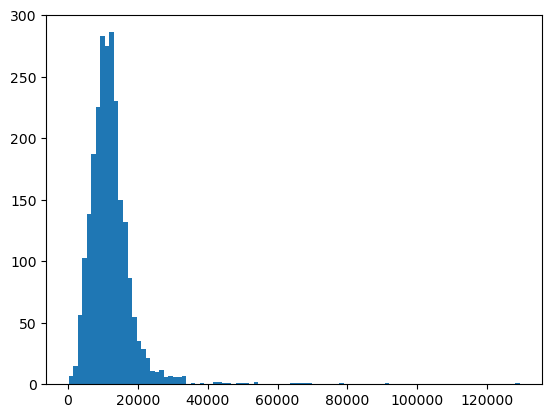

In [26]:
import matplotlib.pyplot as plt

folder_path= '/Users/joanvelja/Documents/1000Kelvin/data/arxiv_mmd/processed'

char_tokens = []
sentence_tokens = []
word_tokens = []

for (dirpath, dirnames, filenames) in os.walk(folder_path):
    for filename in filenames:
        try:
            with open(os.path.join(dirpath, filename), 'r') as f:
                text = f.read()
                if 'LPBF' or 'Laser Powder Bed Diffusion' in text:
                    char_tokens.append(estimate_tokens_by_characters(text.strip().replace('\n', ' ')))
                    sentence_tokens.append(estimate_tokens_by_sentences(text.strip().replace('\n', ' ')))
                    word_tokens.append(estimate_tokens_by_words(text.strip().replace('\n', ' ')))
        except:
            continue

print(f'{len(char_tokens)} papers containing the acronym LPBF found.')
print('Average number of tokens per paper: ', sum(char_tokens) / len(char_tokens))
print('Median number of tokens per paper: ', sorted(char_tokens)[len(char_tokens) // 2])

plt.hist(char_tokens, bins=100)
plt.show()


From the above, we can see that the average token count is around 12000 tokens. This means that the average cost of a single prompting of the LLM is given by:
$$\text{PCost} = \frac{12000 + 550}{1000} \times \text{Per 1k token cost} \approx 12.55 \times \text{Per 1k token cost}$$
$$\text{GCost} = \frac{\text{Context Length}}{1000} \times \text{Per 1k token cost}$$

From the above, we can break down some costs:

* **GPT-4**: Capped at 8k tokens, thus 
$$PCost = 12.55 \times \text{Per 1k token cost} = 12.55 \times 0.03 = 0.3765 \text{\$ per prompt}$$
$$GCost = \frac{1200}{1000} \times \text{Per 1k token cost} = 1.200 \times 0.06 = 0.072 \text{\$ per answer}$$
$$\text{Total Cost} = 0.3765 + 0,072 = 0.4485 \text{ \$ per paper}$$



  Note that answer means multiple JSON responses, usually 3-4 (tested on GPT4). This implies that GPT generates around 1.2k tokens per answer. 



* **GPT-4-32K**: Capped at 32k tokens, thus
$$PCost = 12.55 \times \text{Per 1k token cost} = 12.55 \times 0.06 = 0.753 \text{\$ per prompt}$$
$$GCost = \frac{1200}{1000} \times \text{Per 1k token cost} = 1.2 \times 0.12 = 0.144 \text{\$ per answer}$$
$$\text{Total Cost} = 0.753 + 0.144 = 0.897 \text{ \$ per paper}$$

Note that answer means multiple JSON responses, usually 3-4 (tested on GPT4). WARNING: I haven't tested GPT-4-32K's output length. It may output more than 1.2k tokens per answer. 


* **Claude v1**: Capped at 100k tokens, thus
$$PCost = 12.55 \times \text{Per 1k token cost} = 12.55 \times 0.00163 \approx 0.02 \text{\$ per prompt}$$
$$GCost = \frac{x}{1000} \times \text{Per 1k token cost} = x \times 0.00551 \approx 0.006x \text{\$ per answer}$$

$$\text{Total Cost} \approx 0.02 + 0.006x \text{ \$ per paper}$$

Note that Claude has a massive context length. Although the issue is that I have no access to the model (still unavailable in the EU).


* **Claude v2**: Capped at 100k tokens, thus
$$PCost = 12.55 \times \text{Per 1k token cost} = 12.55 \times 0.01102 \approx 0.138 \text{\$ per prompt}$$
$$GCost = \frac{x}{1000} \times \text{Per 1k token cost} = x \times 0.03268 \approx 0.033x \text{\$ per answer}$$

$$\text{Total Cost} \approx 0.138 + 0.033x \text{ \$ per paper}$$

Note that Claude has a massive context length. Although the issue is that I have no access to the model (still unavailable in the EU).


* **GPT-3.5**: Capped at 16k tokens, thus
$$PCost = 12.55 \times \text{Per 1k token cost} = 12.55 \times 0.003  \approx 0.038  \text{\$ per prompt}$$
$$GCost = \frac{1200}{1000} \times \text{Per 1k token cost} = 1.2 \times 0.004 \approx 0.005 \text{\$ per answer}$$
  Note I am assuming that GPT-3 generates around 1.2k tokens per answer.

$$\text{Total Cost} \approx 0.038 + 0.005 \approx 0.043 \text{ \$ per paper}$$

Recapping:

<center>
    <table>
    <tr>
        <td> <b>Model</b> </td> <td> <b>Cost per paper</b></td> <td> <b>Total cost </b></td> 
    </tr>
    <tr>
        <td> GPT-4 </td> <td> 0.4485 </td> <td> 1031.1015 </td>
    </tr>
    <tr>
        <td> GPT-4-32K </td> <td> 0.897 </td> <td> 2062.203 </td>
    </tr>
    <tr>
        <td> Claude v1 </td> <td> 0.02 + 0.006x </td> <td> 46 + 13.8x </td>
    </tr>
    <tr>
        <td> Claude v2 </td> <td> 0.138 + 0.033x </td> <td> 317.4 + 76.2x </td>
    </tr>
    <tr>
        <td> GPT-3.5 </td> <td> 0.043 </td> <td> 98.9 </td>
    </tr>
</table>
</center>

## **Pipeline**

After we got our OpenRouter API key, we need to install OpenAI python library and import some modules:

In [ ]:
!pip install openai

In [ ]:
temperature = .2
number_of_examples = 3
model = 'openai/gpt-4-32K'
paper = """
**Zirconia UV-curable colloids for additive manufacturing via hybrid inkjet printing-stereolithography**

Rosa M.\({}^{1}\)*, Barou C.\({}^{2}\) and Esposito V.\({}^{1}\)

\({}^{1}\)DTU Energy, Technical University of Denmark, Riso Campus, Frederiksborgvej 399, 4000, Roskilde, Denmark.

\({}^{2}\) ENSIL-ENSCI, Parc Ester Technopole, 16 rue Atlantis, 87068 Limoges Cedex, France.

*corresponding author: masros@dtu.dk

**Abstract**

Currently, additive manufacturing of ceramics by stereolithography (SLA) is limited to single materials and by a poor thickness resolution that strongly depends on the ceramic particles-UV light interaction. Combining selective laser curing with inkjet printing represents a novel strategy to overcome these constrains. Nonetheless, this approach requires UV-curable inks that allow hardening of the printed material and sintering to high density. In this work, we report how to design an ink for inkjet printing of yttria stabilized zirconia (YSZ) which can be impressed by addition of UV-curable monomers. We especially show how the formulation of the inks and particularly the UV-monomer concentration impacts the printability and the UV-curing. This leads to prints that are resistant to solvent washing first and densify to 96% dense YSZ layers after sintering.

**Keywords:** inkjet printing; UV-curable; zirconia; sintering.

**Introduction**

Stereolithography (SLA) is an additive manufacturing technique where a 3D structure is built adding material in a layer-by-layer fashion, and consolidating selectively each layer with a laser scan or projected light [1]. In the case of ceramic materials, SLA can be used for sintering driedpowders with a high-intensity laser [2]. This method, known as direct selective laser sintering, is successfully applied to metals, but has shown limitations for ceramics due to residual porosity and low spatial resolution. Differently, the most typical SLA approach for these materials employs ceramic colloids dispersed in a UV-sensitive medium. With this method it is possible to shape complex ceramic structures by selective curing, and achieve full density after sintering [3]. In this configuration, the addition of material is carried out by a doctor blade, which distributes the uncured ceramic slurry, regulating the layer thickness. This mechanism introduces two main limitations in the SLA process, _i.e._ single-material manufacturing and a poor thickness resolution of ca. 10 \(\upmu\)m. Other AM techniques, such as micro-extrusion, screen printing and fused deposition modeling, show even worse thickness and lateral resolutions, generally in the order of hundreds of microns [4, 5].

On the other hand, inkjet printing consists in the deposition of small droplets of ink (typical volume 10-12 - 10-9 L) allowing local deposition of thin layers (\(<\)1 \(\upmu\)m) of different materials [6]. Although inkjet printing has been used to print thick structures [7], its most successful application in ceramics lies in the deposition of thin layers. Therefore, due to the higher spatial resolution and multi-material capabilities of inkjet, combining the latter with SLA represents a possible solution to the aforementioned limitations in the additive manufacturing of ceramics.

The feedstock materials used in SLA and inkjet printing possess, however, very different properties. In the case of SLA, highly viscous pastes are employed (solid loading ca. 50% vol), while, inkjet uses diluted, low viscosity inks (typical solid loading ca. 1% vol). Therefore, combining these two techniques requires UV-curable inks which allow reaching high density after sintering. UV-curable inks loaded with inorganic particles have been already developed [8]. However, they are designed to obtain a polymeric composite reinforced with ceramic particlesand not a precursor of a full-ceramic material [5, 8]. The formulation of a UV-curable ink dedicated to the fabrication of functional ceramic components by inkjet is thus missing.

The addition of ceramic particles into a UV-curable ink introduces several issues that have to be addressed in the ink formulation. Especially, particles can increase the ink viscosity [9], becoming too high for inkjet printing, and scatter the UV-radiation hindering the UV-curing reaction [1, 10]. In this letter, we report the formulation of a UV-curable ink for inkjet printing of yttria-stabilized-zirconia (YSZ), a widely used ceramic in SLA manufacturing. We especially studied the impact of the polymer amount on the printability of the ink, hardening time and final microstructure, aiming to full dense sintered layers.

## Experimental

A detailed description of the materials and methods used is gives in the supplementary information.

## Results

TMPTA is a highly reactive monomer used in UV-curable inks as a cross-linking additive due to its triple acrylic functionality [11]. In this work, TMPTA was selected as a pure structural monomer to compensate for the presence of YSZ particles, which hinder cross-linking. In addition, due to its low molecular weight, the tendency of forming polymeric aggregates during the jetting is reduced [12], preventing clogging. IPA was selected as solvent for its low viscosity (1.95 mPa s), low surface tension (23 mN m-1) and low toxicity.

A TMPTA-free 8YSZ ink with a solid loading of 8.7% wt was formulated as a reference for the preparation of the UV-curable ink. The formulation showed a single peak size distribution with a maximum at 200 nm and no particles above 400 nm.

Two inks were formulated by adding 1.25% wt and 11% wt of TMPTA10 to the first ink. The volume ratios between TMPTA10 and 8YSZ particles in the two inks are 1:0.8 and 1:7.8. These two ratios were chosen to investigate the effect of the polymer amount on the printability and solvent resistance. Interestingly, the viscosity decreased from 2.81 mPa s to 2.71 mPa s and 2.12 mPa s upon the addition of 1.25% wt and 11% wt of TMPTA10 (Fig. 1). This result suggests that TMPTA10 might contribute to the dispersion of the 8YSZ particles, lowering the viscosity. After measuring density and surface tension, the printability parameters \(Z\) for these two inks were calculated. The ink printability is defined by equation (1): \(Z=1/Oh=(\rho\cdot\sigma\cdot a)^{1/2}/\eta\), where \(\rho\) is the density, \(\sigma\) is the surface tension, \(\eta\) is the viscosity, and \(a\) is the nozzle diameter. According to

Figure 1: viscosity of the YSZ ink in IPA with different amounts of TMPTA10.

the previous work by Derby [6] an ink is not jettable if Z\(<\)1, while multiple droplets are generated when Z\(>\)10.

As reported in table 1, all the inks were formulated to be in the ideal range of Z for a proper jetting behavior. Viscosity, surface tension and density used to calculate the Z parameter of the three inks are summarized in table 1.

\begin{table}
\begin{tabular}{c c c c c c} \hline
**Ink** & **\%wt of TMPTA** & **\(\eta\) [mPa s]** & **\(\sigma\) [mN m\({}^{\text{-1}}\)]** & **\(\rho\) [g/cm\({}^{\text{-3}}\)]** & **Z** \\ \hline
**1** & - & 2.81 & 20.4 & 0.813 & 6.7 \\ \hline
**2** & 1.25 & 2.71 & 20.4 & 0.828 & 7.0 \\ \hline
**3** & 11.0 & 2.12 & 21.1 & 0.849 & 9.2 \\ \hline \end{tabular}
\end{table}
Table 1: measured viscosity at 1000 s\({}^{\text{-1}}\) (\(\eta\)), surface tension (\(\sigma\)), density (\(\rho\)) and calculated printability Z.

Figure 2: (a) single jetted droplets, (b), (c), (d) optimization of the printing process to achieve a uniform layer, (e) curing, (f) washing test with ethanol on a sample with 11% wt TMPTA10, and without TMPTA10 (g). The area covered with ethanol is on the right side of the dotted line.

Figure 2(a) shows the typical jetting behavior obtained with the formulated inks. According to the calculated printability, the jetting of these inks shows a single round-shaped droplet. The inkjet printing process was optimized on a glass substrate by controlling the number deposited droplets per inch (DPI). Figure 2(b) shows that 100 DPI led to an incomplete coverage of the surface and it was possible to distinguish single splats with a diameter of ca. 130 \(\upmu\)m. Using a resolution of 250 DPI the deposited layer was uniform (Fig. 2(c)), while with 400 DPI the splats overlapped, forming an uneven surface (Fig. 2(d)). Therefore, an areal density of 250 DPI was applied for printing multilayered samples that were cured with UV light, Fig. 2(e).

To evaluate the solvent resistance and mimic the cleaning process for removing uncured material, the cured samples were observed after exposing them to ethanol, Fig. 2(f) and 2(g). Our results showed no difference in the solvent resistance of 20 minutes cured samples with a TMPTA10 content up to 1.25% wt. Fig. 2(g) shows that ethanol caused the immediate re-dispersion of the particles, which accumulate in the circled area. On the other hand, the inkjet-printed sample with 11% wt of TMPTA10 showed no significant changes in the structure of the film after the washing test. Notably, this result was achieved without operating in controlled atmosphere or adding oxygen scavengers, which are often needed to achieve curing in air.

Due to the good resistance to ethanol of the formulation with 11%wt of TMPTA10, this ink was used for investigating the sintering of the 8YSZ prints. Squared samples made of 5 and 10 layers were printed on a green 3YSZ substrate and co-sintered in air after curing.

Figure 3 reports the microstructure of the two samples: Fig. 3(a) and Fig. 3(b) show that the number of printed layers influenced the final structure of the sintered material. In particular, crack formation in the 10-layered sample is due to the shrinkage mismatch between support and deposition, which is caused by their different green densities, i.e. 50% vs 12%, respectively. This difference led to the formation of tensile stresses during sintering, which are more pronounced in the thicker 10-layered sample. As a consequence this sample cracked while the thinner 5-layered showed a crack-free microstructure. Fig. 3(a) also shows a non-uniform distribution of the porosity that is due to the coffee stain effect. In particular, this drying effect left regions with higher concentrations of TMPTA, which resulted in a local higher porosity. Nonetheless, the substrate coverage is complete with a maximum relative density up to 96% vol (Fig. 3(c)). High

Figure 3: microstructural characterization after sintering. (a), (b) Top views of the 5-layered and 10-layered samples. (c), (d) Magnified microstructures of the 5-layered and 10-layered samples.

densification, despite the low density, indicates a good particle packing as a result of well dispersed ceramic particles in the ink [13].

## Conclusions

In this work, we report the formulation of a UV-curable ink for the fabrication of YSZ structures by a combination of SLA and inkjet printing. The developed ink allows stable jetting and contains 8.7% wt of 8YSZ particles and 11% wt of TMPTA as a monomer. The printed deposit is cured without operating in a controlled atmosphere or adding oxygen scavengers, becoming stable to ethanol. After curing, the 8YSZ particles can be sintered at 1295 \({}^{\circ}\)C, reaching relative densities up to 96%. This result opens the possibility to apply the ink with 11%wt of TMPTA10 for patterning 8YSZ inkjet-printed films by selective curing.

## Aknowledgements

This project has partially received funding from the Fuel Cells and Hydrogen 2 Joint Undertaking under grant agreement No 700266. This Joint Undertaking receives support from the European Union's Horizon 2020 research and innovation program and Hydrogen Europe and N.ERGHY.
"""

In [ ]:
import os
import openai
import random

openai.api_base = "https://openrouter.ai/api/v1"
openai.api_key = os.getenv("YOUR_OPENROUTER_API_KEY")
OPENROUTER_REFERRER = "https://github.com/gitrepo"


def generate_example(model, prev_examples, paper, temperature=.5, content=prompt_gpt):
    content = content.strip()  # Remove leading/trailing whitespace

    messages=[
        {
            "role": "system",
            "content": content + paper
        }
    ]

    if len(prev_examples) > 0:
        if len(prev_examples) > 10:
            prev_examples = random.sample(prev_examples, 10)
        for example in prev_examples:
            messages.append({
                "role": "assistant",
                "content": example
            })

    response = openai.ChatCompletion.create(
        model=model,
        headers={
            "HTTP-Referer": OPENROUTER_REFERRER
        },
        messages=messages,
        temperature=temperature,
        max_tokens=1354,
    )

    return response.choices[0].message['content']

# Generate examples
prev_examples = []
for i in range(number_of_examples):
    print(f'Generating example {i}')
    example = generate_example(model, prev_examples, paper, temperature)
    prev_examples.append(example)

print(prev_examples)

Now let's put our examples into a dataframe and turn them into a processed dataset.

In [1]:
prev_examples = ['''
Hello, this is a test.
{
  "name": "John",
  "age": 30,
  "city": "New York",
  "details": {
    "hobbies": ["reading", "swimming"],
    "isMarried": true
  }
}
And this is the end of the first test.
''', '''
Multiple JSON objects are here.
{
  "instruction": "Explain the concept of black holes.",
  "input": "Black holes are regions of spacetime where gravity is so strong that not even light can escape.",
  "output": "Black holes are areas in space where the gravitational pull is so intense that nothing, not even light, can escape them."
}
{
  "instruction": "What is the speed of light?",
  "input": "The speed of light in a vacuum is approximately 299,792 kilometers per second.",
  "output": "The speed of light is about 299,792 km/s when measured in a vacuum."
}
End of text.
''',
'''
Complex with nested objects and arrays.
{
  "employees": [
    {"firstName": "John", "lastName": "Doe"},
    {"firstName": "Anna", "lastName": "Smith"},
    {"firstName": "Peter", "lastName": "Jones"}
  ],
  "department": {
    "name": "Engineering",
    "floor": 7,
    "projects": ["Project A", "Project B", {"specialProject": "Project X"}]
  }
}
End of this test.
''']

In [3]:
import json
import re

def find_json_objects(input_string):
    """
    Find all JSON-like objects in a string.
    """
    stack = []
    json_objects = []
    json_start = 0

    for i, c in enumerate(input_string):
        if c == '{':
            stack.append('{')
            if len(stack) == 1:
                json_start = i
        elif c == '}':
            if stack:
                stack.pop()
                if len(stack) == 0:
                    json_objects.append(input_string[json_start:i+1])

    return json_objects

def parse_json_from_string(input_string):
    """
    Parse JSON objects from a given string and return them as a list of dictionaries.
    """
    json_strings = find_json_objects(input_string)
    parsed_json_list = []

    for json_str in json_strings:
        try:
            parsed_json = json.loads(json_str)
            parsed_json_list.append(parsed_json)
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            
    return parsed_json_list

In [9]:
jsons = []
for example in prev_examples:
    try:
        parsed_json = parse_json_from_string(example)
        jsons.append(parsed_json)
    except:
        print('Failed to parse JSON')
        pass


In [8]:
def extract_pairs(parsed_json_list):
    instructions = []
    inputs = []
    outputs = []
    for i, parsed_json in enumerate(parsed_json_list):
        for key, value in parsed_json.items():
            if key == 'instruction':
                instructions.append(value)
            elif key == 'input':
                inputs.append(value)
            elif key == 'output':
                outputs.append(value)
            else:
                print(f'Unknown key: {key}')
    
    return instructions, inputs, outputs
 

[{'name': 'John',
  'age': 30,
  'city': 'New York',
  'details': {'hobbies': ['reading', 'swimming'], 'isMarried': True}}]

In [ ]:
instructions, inputs, outputs = extract_pairs(jsons)

# Create a DataFrame
df = pd.DataFrame({
    'Instruction': instructions,
    'Input': inputs,
    'Output': outputs
})

# Remove duplicates
df = df.drop_duplicates()

print('There are ' + str(len(df)) + ' successfully-generated examples. Here are the first few:')

df.head()

### **Split into train and test**

In [ ]:
# Split the data into train and test sets, with 90% in the train set
train_df = df.sample(frac=0.9, random_state=42)
test_df = df.drop(train_df.index)

# Save the dataframes to .jsonl files
train_df.to_json('train.jsonl', orient='records', lines=True)
test_df.to_json('test.jsonl', orient='records', lines=True)

##### **Install libraries**

In [ ]:
!pip install "transformers==4.34.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.23.0" "bitsandbytes==0.41.1" "trl==0.4.7" "safetensors>=0.3.1" --upgrade

To instruct tune our model, we need to convert our structured examples into a collection of tasks described via instructions. We define a `formatting_function` that takes a sample and returns a string with our format instruction.

In [ ]:
def format_instruction(sample):
	return f"""### Instruction:
Use the Input below to create an instruction, which could have been used to generate the input using an LLM.

### Input:
{sample['response']}

### Response:
{sample['instruction']}
"""

We will use the recently introduced method in the paper "QLoRA: Quantization-aware Low-Rank Adapter Tuning for Language Generation" by Tim Dettmers et al. 
QLoRA is a new technique to reduce the memory footprint of large language models during finetuning, without sacrificing performance. The TL;DR; of how QLoRA works is:

* Quantize the pre-trained model to 4 bits and freeze it.
* Attach small, trainable adapter layers. (LoRA)
* Finetune only the adapter layers while using the frozen quantized model for context.

Flash Attention is a an method that reorders the attention computation and leverages classical techniques (tiling, recomputation) to significantly speed it up and reduce memory usage from quadratic to linear in sequence length. It is based on the paper "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness". 
The TL;DR; accelerates training up to 3x. Flash Attention is currently only available for Ampere (A10, A40, A100, ...) & Hopper (H100, ...) GPUs.

In [ ]:
!python -c "import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'"
%pip install ninja packaging
!MAX_JOBS=4 pip install flash-attn --no-build-isolation

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

use_flash_attention = False

# Hugging Face model id
model_id = "NousResearch/Llama-2-7b-hf"  # non-gated
# model_id = "meta-llama/Llama-2-7b-hf" # gated


# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    use_flash_attention_2=use_flash_attention,
    device_map="auto",
)
model.config.pretraining_tp = 1


tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

The SFTTrainer supports a native integration with peft, which makes it super easy to efficiently instruction tune LLMs. We only need to create our LoRAConfig and provide it to the trainer.

In [ ]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# LoRA config based on QLoRA paper
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.1,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
)


# prepare model for training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

Before we can start our training we need to define the hyperparameters (TrainingArguments) we want to use. We will use the following hyperparameters:

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="llama-7b-1000K",
    num_train_epochs=3,
    per_device_train_batch_size=6 if use_flash_attention else 4,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    disable_tqdm=False
)

We now have every building block we need to create our SFTTrainer to start then training our model.

In [ ]:
# load path to jsonl
#train_df = ...

In [ ]:
from trl import SFTTrainer

max_seq_length = 2048 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    train_dataset=train_df,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    packing=True,
    formatting_func=format_instruction,
    args=args,
)

In [ ]:
#train
trainer.train() 

# save model
trainer.save_model()

The training without Flash Attention enabled should take around 3hrs. The instance costs 1.212$/h which brings us to a total cost of 3.7$. The training with Flash Attention enabled should take around 2hrs on a g5.2xlarge. The instance costs 1.212$/h which brings us to a total cost of 2.6$.

### **Test Model and run Inference**

After the training is done we want to run and test our model. We will use peft and transformers to load our LoRA adapter into our model.

In [ ]:
if use_flash_attention:
    # unpatch flash attention
    from utils.llama_patch import unplace_flash_attn_with_attn
    unplace_flash_attn_with_attn()

import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

args.output_dir = "llama-7b-1000K"

# load base LLM model and tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(
    args.output_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(args.output_dir)